# Knowledge Base Embeddings & Visualization

This notebook loads all entries from the `data/knowledge_base/` directory, generates embeddings, and visualizes them in a 2D PCA plot color-coded by difficulty level.

## Purpose
1.  **Load Knowledge Base**: Read all `.jsonl` files from `data/knowledge_base/`.
2.  **Generate Embeddings**: Combine **Topics (highest priority)** + Task + Code for each entry.
3.  **Visualize with PCA**: 2D scatter plot showing semantic similarity.
4.  **Color-code by Difficulty**: Beginner, Intermediate, Advanced.
5.  **Statistics**: Display summary information about the knowledge base.

## Ranking Priority
- **Topics**: Highest priority (placed first in embedding text)
- **Task/Description**: Medium priority
- **Code**: Lower priority


In [1]:
# Setup and Imports
import sys
import json
from pathlib import Path

# Add project root to path
project_root = Path("..").resolve()
sys.path.insert(0, str(project_root))

# Import config from root config folder
from config import get_config, get_config_loader

# Import other modules
from src.rag.embeddings import EmbeddingModel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print("✅ Imports successful!")

✅ Imports successful!


## 1. Load Knowledge Base Entries

In [2]:
# Define Knowledge Base Path
KNOWLEDGE_BASE_DIR = project_root / "data" / "knowledge_base"

entries = []

# Load all .jsonl files
for jsonl_file in KNOWLEDGE_BASE_DIR.glob("*.jsonl"):
    print(f"Loading: {jsonl_file.name}")
    with open(jsonl_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                entries.append(json.loads(line))

print(f"\n✅ Loaded {len(entries)} entries from knowledge base.")

Loading: curated_designer_examples.jsonl

✅ Loaded 102 entries from knowledge base.


## 2. Knowledge Base Statistics

In [3]:
# Calculate Statistics
from collections import Counter

difficulties = [e.get('difficulty', 'unknown') for e in entries]
difficulty_counts = Counter(difficulties)

all_topics = []
for e in entries:
    all_topics.extend(e.get('topics', []))
topic_counts = Counter(all_topics)

print("=" * 60)
print("Knowledge Base Statistics")
print("=" * 60)
print(f"Total Entries: {len(entries)}")
print(f"\nDifficulty Breakdown:")
for diff, count in difficulty_counts.most_common():
    print(f"  - {diff.capitalize()}: {count}")

print(f"\nTop 10 Topics:")
for topic, count in topic_counts.most_common(10):
    print(f"  - {topic}: {count}")
print("=" * 60)

Knowledge Base Statistics
Total Entries: 102

Difficulty Breakdown:
  - Advanced: 50
  - Intermediate: 41
  - Beginner: 11

Top 10 Topics:
  - oracle: 10
  - general: 10
  - measurement: 8
  - entanglement: 7
  - simulation: 6
  - qec: 6
  - qaoa: 6
  - qpe: 6
  - vqe: 6
  - deutsch_jozsa: 5


## 3. Initialize Embedding Model & Generate Embeddings

In [4]:
# Initialize configuration
config_loader = get_config_loader()
config = config_loader.config

# Create embedding model
embedding_model = EmbeddingModel(
    model_name=config.get("models.embedding.model_name"),
    device=config.get("models.embedding.device"),
)

print(f"✅ Embedding model loaded: {embedding_model.model_name}")
print(f"Embedding dimension: {embedding_model.get_embedding_dimension()}")
print(f"Device: {embedding_model.device}")

2025-12-05 23:09:08.205 | INFO     | config.config_loader:load:93 - ✅ Loaded configuration from D:\University\Uni\Semester 7\Generative AI\Project\Cirq-RAG-Code-Assistant\config\config.dev.json
2025-12-05 23:09:08.207 | DEBUG    | config.config_loader:create_directories:236 - Created all necessary directories
2025-12-05 23:09:08.208 | INFO     | config_loader:load:93 - ✅ Loaded configuration from D:\University\Uni\Semester 7\Generative AI\Project\Cirq-RAG-Code-Assistant\config\config.dev.json
2025-12-05 23:09:08.209 | DEBUG    | config_loader:create_directories:236 - Created all necessary directories
2025-12-05 23:09:08.210 | INFO     | src.rag.embeddings:__init__:97 - Loading embedding model: BAAI/bge-base-en-v1.5
2025-12-05 23:09:08.210 | INFO     | src.rag.embeddings:__init__:98 - Using device: cpu
2025-12-05 23:09:12.839 | INFO     | src.rag.embeddings:__init__:106 - ✅ Embedding model loaded successfully
2025-12-05 23:09:12.840 | INFO     | src.rag.embeddings:__init__:113 - Embeddi

✅ Embedding model loaded: BAAI/bge-base-en-v1.5
Embedding dimension: 768
Device: cpu


In [5]:
# Prepare texts for embedding
# PRIORITY ORDER: Topics (HIGHEST) > Task > Code
# Topics are placed FIRST to give them highest weight in the embedding
texts_to_embed = []
entry_ids = []
entry_difficulties = []

for e in entries:
    # Get components
    topics = e.get('topics', [])
    task = e.get('task', e.get('description', ''))
    code = e.get('code', '')
    
    # Topics FIRST (highest priority), then task, then code
    topics_str = ', '.join(topics) if topics else ''
    combined_text = f"Topics: {topics_str}\n\nTask: {task}\n\nCode:\n{code}"
    
    texts_to_embed.append(combined_text)
    entry_ids.append(e.get('id', 'unknown'))
    entry_difficulties.append(e.get('difficulty', 'unknown'))

print(f"Prepared {len(texts_to_embed)} entries for embedding.")
print(f"\n📋 Embedding text format (Topics have HIGHEST priority):")
print("-" * 50)
print(texts_to_embed[0][:400] + '...')

Prepared 102 entries for embedding.

📋 Embedding text format (Topics have HIGHEST priority):
--------------------------------------------------
Topics: arithmetic, adder, toffoli

Task: Design a reusable Cirq gate or function implementing a ripple-carry adder for n-bit integers using Toffoli and CNOT gates.

Code:
import cirq

class RippleCarryAdder(cirq.Gate):
    def __init__(self, num_bits: int):
        self._num_bits = num_bits

    def num_qubits(self) -> int:
        return 3 * self._num_bits

    def _decompose_(self, qubits):
   ...


In [6]:
# Generate embeddings
print("Generating embeddings... (this may take a moment)")
embeddings = embedding_model.encode(
    texts_to_embed,
    batch_size=config.get("models.embedding.batch_size", 16),
    show_progress_bar=True,
)

print(f"\n✅ Generated embeddings of shape: {embeddings.shape}")

2025-12-05 23:09:12.853 | DEBUG    | src.rag.embeddings:encode:166 - Generating embeddings for 102 texts


Generating embeddings... (this may take a moment)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]


✅ Generated embeddings of shape: (102, 768)


## 4. Visualize with PCA (Color-coded by Difficulty)

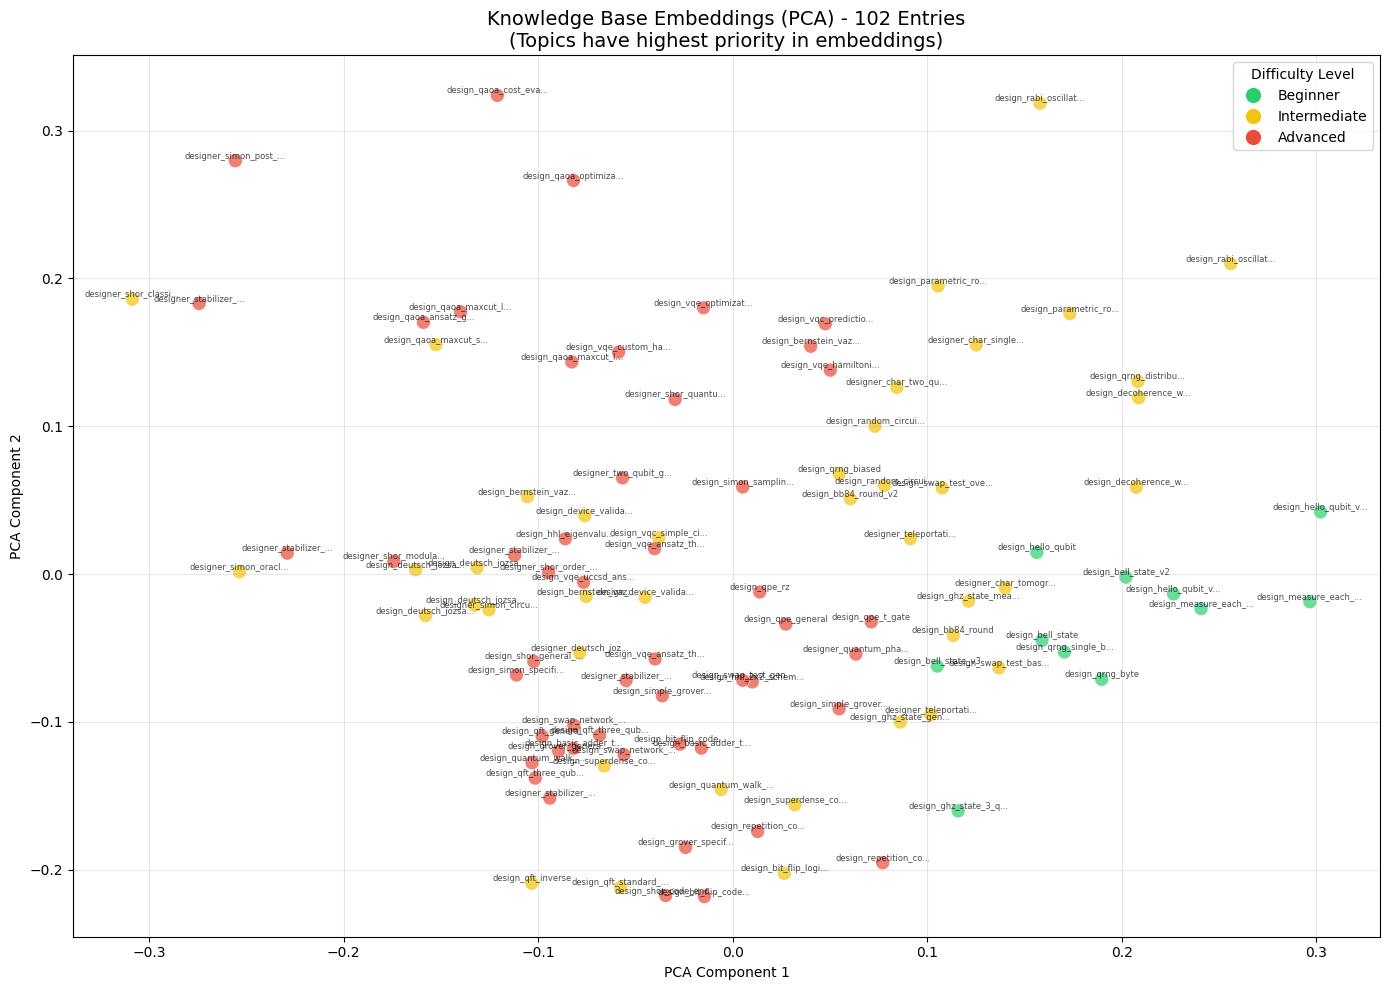


✅ Visualization complete!
PCA Explained Variance: 13.04%


In [7]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Define color mapping for difficulty levels
difficulty_colors = {
    'beginner': '#2ecc71',       # Green
    'intermediate': '#f1c40f',   # Yellow/Orange
    'advanced': '#e74c3c',       # Red
    'unknown': '#95a5a6',        # Gray
}

# Assign colors to each entry
colors = [difficulty_colors.get(d, '#95a5a6') for d in entry_difficulties]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 10))

scatter = ax.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=colors,
    s=100,
    alpha=0.7,
    edgecolors='white',
    linewidths=0.5
)

# Add labels (entry IDs)
for i, entry_id in enumerate(entry_ids):
    # Shorten long IDs
    short_id = entry_id[:20] + '...' if len(entry_id) > 20 else entry_id
    ax.annotate(
        short_id,
        (embeddings_2d[i, 0], embeddings_2d[i, 1]),
        fontsize=6,
        alpha=0.7,
        ha='center',
        va='bottom',
    )

# Create legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=difficulty_colors['beginner'], markersize=12, label='Beginner'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=difficulty_colors['intermediate'], markersize=12, label='Intermediate'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=difficulty_colors['advanced'], markersize=12, label='Advanced'),
]
ax.legend(handles=legend_elements, loc='upper right', title='Difficulty Level')

ax.set_title(f"Knowledge Base Embeddings (PCA) - {len(entries)} Entries\n(Topics have highest priority in embeddings)", fontsize=14)
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Visualization complete!")
print(f"PCA Explained Variance: {pca.explained_variance_ratio_.sum():.2%}")

## 5. Sample Entry Preview

In [8]:
# Display a few sample entries
print("=" * 60)
print("Sample Knowledge Base Entries")
print("=" * 60)

for i, e in enumerate(entries[:3]):
    print(f"\n--- Entry {i+1}: {e.get('id', 'N/A')} ---")
    print(f"Difficulty: {e.get('difficulty', 'N/A')}")
    print(f"Topics: {', '.join(e.get('topics', []))}")
    print(f"Task: {e.get('task', e.get('description', 'N/A'))[:150]}...")
    print(f"Code Preview: {e.get('code', 'N/A')[:100]}...")

Sample Knowledge Base Entries

--- Entry 1: design_basic_adder_template ---
Difficulty: advanced
Topics: arithmetic, adder, toffoli
Task: Design a reusable Cirq gate or function implementing a ripple-carry adder for n-bit integers using Toffoli and CNOT gates....
Code Preview: import cirq

class RippleCarryAdder(cirq.Gate):
    def __init__(self, num_bits: int):
        self....

--- Entry 2: design_basic_adder_template_v2 ---
Difficulty: advanced
Topics: arithmetic, adder
Task: Show how to use the RippleCarryAdder gate to add two specific 3-bit classical numbers by initializing the a and b registers and measuring the sum....
Code Preview: import cirq

# Assume RippleCarryAdder is defined as before

n = 3
qubits = cirq.LineQubit.range(3 *...

--- Entry 3: design_bb84_round ---
Difficulty: intermediate
Topics: bb84, cryptography, basis_encoding
Task: Write a Cirq circuit that implements one round of the BB84 protocol on a single qubit: Alice chooses a random bit and basis, encodes it, a

## 6. Model Information

In [9]:
print("Embedding Model Information:")
print("=" * 60)
print(f"Model Name: {embedding_model.model_name}")
print(f"Embedding Dimension: {embedding_model.get_embedding_dimension()}")
print(f"Device: {embedding_model.device}")
print(f"Model Type: {type(embedding_model.model).__name__}")
print("=" * 60)

stats = embedding_model.get_stats()
print(f"\nEmbedding Statistics:")
print(f"  Total embeddings generated: {stats['total_embeddings']}")
print(f"  Total batches processed: {stats['total_batches']}")

print(f"\n📌 Ranking Priority Used:")
print(f"  1. Topics (HIGHEST priority)")
print(f"  2. Task/Description")
print(f"  3. Code")

Embedding Model Information:
Model Name: BAAI/bge-base-en-v1.5
Embedding Dimension: 768
Device: cpu
Model Type: SentenceTransformer

Embedding Statistics:
  Total embeddings generated: 102
  Total batches processed: 1

📌 Ranking Priority Used:
  1. Topics (HIGHEST priority)
  2. Task/Description
  3. Code
